# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [10]:
!pip install apache-beam[interactive]

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 59.2 MB 93 kB/s s eta 0:00:01   |▋                               | 1.2 MB 3.3 MB/s eta 0:00:18     |█                               | 1.7 MB 3.3 MB/s eta 0:00:18     |█▎                              | 2.4 MB 3.3 MB/s eta 0:00:17     |█▉                              | 3.4 MB 3.3 MB/s eta 0:00:17     |█████                           | 9.3 MB 3.3 MB/s eta 0:00:15     |███████▏                        | 13.3 MB 3.3 MB/s eta 0:00:14     |████████                        | 14.6 MB 3.3 MB/s eta 0:00:14     |████████▌                       | 15.7 MB 3.3 MB/s eta 0:00:13     |█████████▏                      | 17.0 MB 3.3 MB/s eta 0:00:13     |██████████▌                     | 19.5 MB 24.6 MB/s eta 0:00:02     |███████████▉                    | 22.0 MB 24.6 MB/s eta 0:00:02     |████████████▌                   | 23.2 MB 24.6 MB/s eta 0:00:02     |█████████████▉                  | 2

  Created wheel for timeloop: filename=timeloop-1.0.2-py3-none-any.whl size=3722 sha256=535bebeca836b7ca7a93a69b9613e788d780d1d323c695b805b7b77e63d3113a
  Stored in directory: /root/.cache/pip/wheels/3a/7e/fc/5e4d6da12b9ab6550604412936723ec6f2faf7391dd6726a01
  Created wheel for simplegeneric: filename=simplegeneric-0.8.1-py3-none-any.whl size=5073 sha256=cb042c2ca4743f0c2ee7286bbf584b96ccd5bf52a380ce8f1157aebe96e799fa
  Stored in directory: /root/.cache/pip/wheels/90/de/df/f1324f4dd966636ab877b82d467acad38a0998b1c42ddb7288
Successfully built timeloop simplegeneric
ERROR: tfx-bsl 0.21.3 has requirement absl-py<0.9,>=0.7, but you'll have absl-py 0.9.0 which is incompatible.
ERROR: tfx-bsl 0.21.3 has requirement apache-beam[gcp]<2.18,>=2.17, but you'll have apache-beam 2.19.0 which is incompatible.
ERROR: tensorflow-transform 0.21.0 has requirement absl-py<0.9,>=0.7, but you'll have absl-py 0.9.0 which is incompatible.
ERROR: tensorflow-data-validation 0.21.2 has requirement absl-py<0.9,

In [133]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
import student_utils
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import tensorflow_data_validation as tfdv
print('TFDV version: {}'.format(tfdv.version.__version__))

TFDV version: 0.21.2


In [3]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [5]:
df.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO
6,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30
7,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO
8,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO
9,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO


In [6]:
df[df['encounter_id'] == 36900]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
16,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,?,?,157,288|197,0,0,0,62,7,11,0,0115-1743,None,None,Ch,<30
17,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,?,?,157,288|197,0,0,0,62,7,11,0,50090-0353,None,None,Ch,<30


In [7]:
df[df['patient_nbr'] == 135]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
5675,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,42291-559,None,None,Ch,<30
5676,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,0093-9364,None,None,Ch,<30
5677,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,68071-1701,None,None,Ch,<30
6337,26264286,135,Caucasian,Female,[50-60),?,1,1,7,3,?,Surgery-Cardiovascular/Thoracic,998,41|250,0,1,0,31,5,14,1,0087-6070,None,None,Ch,>30
6338,26264286,135,Caucasian,Female,[50-60),?,1,1,7,3,?,Surgery-Cardiovascular/Thoracic,998,41|250,0,1,0,31,5,14,1,0093-9477,None,None,Ch,>30


Perform tests to determine whether data is line level or encounter level:

In [8]:
# Line Test
try:
    assert len(df) > df['encounter_id'].nunique() 
    print("Dataset could be at the line level")
except:
    print("Dataset is not at the line level")

Dataset could be at the line level


In [9]:
# Encounter Test
try:
    assert len(df) == df['encounter_id'].nunique()
    print("Dataset could be at the encounter level")
except:
    print("Dataset is not at the encounter level")

Dataset is not at the encounter level


**Student Response:**


The data is at line level.

In order to aggregate the data at an econounter level, we should use all the fields for grouping except for ndc_code field. The values in all the other fields repeat at an encounter_id and patient_nbr level (except ndc_code).

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

### Clean up data

In [10]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
ndc_code                    object
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
dtype: object

In [4]:
# Clean up columns to remove '[' and ')'.
col_clean = ['age', 'weight']
for col in col_clean:
  df[col] = df[col].str.strip('[')
  df[col] = df[col].str.strip(')')

In [5]:
# Clean up columns to remove '?':
col_list = df.columns
for col in col_list:
  if df[col].dtypes == object:
    df[col] = df[col].str.strip('?')

In [6]:
# clean 'other_diagnosis_code' to remove |
df['other_diagnosis_codes'] = df['other_diagnosis_codes'].str.strip('|')

In [7]:
df.replace('', np.nan, regex=True, inplace=True)
df.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,0-10,NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,NaN,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,10-20,NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,20-30,NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,30-40,NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,40-50,NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
5,16680,42519267,Caucasian,Male,40-50,NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO
6,35754,82637451,Caucasian,Male,50-60,NaN,2,1,2,3,NaN,NaN,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30
7,55842,84259809,Caucasian,Male,60-70,NaN,3,1,2,4,NaN,NaN,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO
8,55842,84259809,Caucasian,Male,60-70,NaN,3,1,2,4,NaN,NaN,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO
9,55842,84259809,Caucasian,Male,60-70,NaN,3,1,2,4,NaN,NaN,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO


### Check for missing values:

In [15]:
# Missing values
def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns,
                            'percent_nan': df.isna().sum() * 100 / len(df),
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df 

In [16]:
null_df = check_null_values(df)
null_df

,columns,percent_nan,percent_null,percent_zero
encounter_id,encounter_id,0.000000,0.000000,0.000000
patient_nbr,patient_nbr,0.000000,0.000000,0.000000
race,race,2.307145,2.307145,0.000000
gender,gender,0.000000,0.000000,0.000000
age,age,0.000000,0.000000,0.000000
weight,weight,97.000502,97.000502,0.000000
admission_type_id,admission_type_id,0.000000,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.000000,0.000000,0.000000
admission_source_id,admission_source_id,0.000000,0.000000,0.000000
time_in_hospital,time_in_hospital,0.000000,0.000000,0.000000


**a. Field(s) with high amount of missing/zero values**

Following fields are Null or NaN:
- weight	(97.000502 %)
- payer_code	(37.783077 %)
- medical_specialty	(48.431922 %)
- other_diagnosis_codes	(0.237059 %)
- ndc_code	(16.358490 %)

Following fields have zeros:
- number_outpatient (83.686831 %)
- number_inpatient (67.421073 %)
- number_emergency (88.858211 %)
- num_procedures (45.869589 %)

### Frequency histogram
Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?

In [17]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=[15,15])
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

In [18]:
num_col = []
for col in df.columns:
  if (df[col].dtypes != object):
    num_col.append(col)

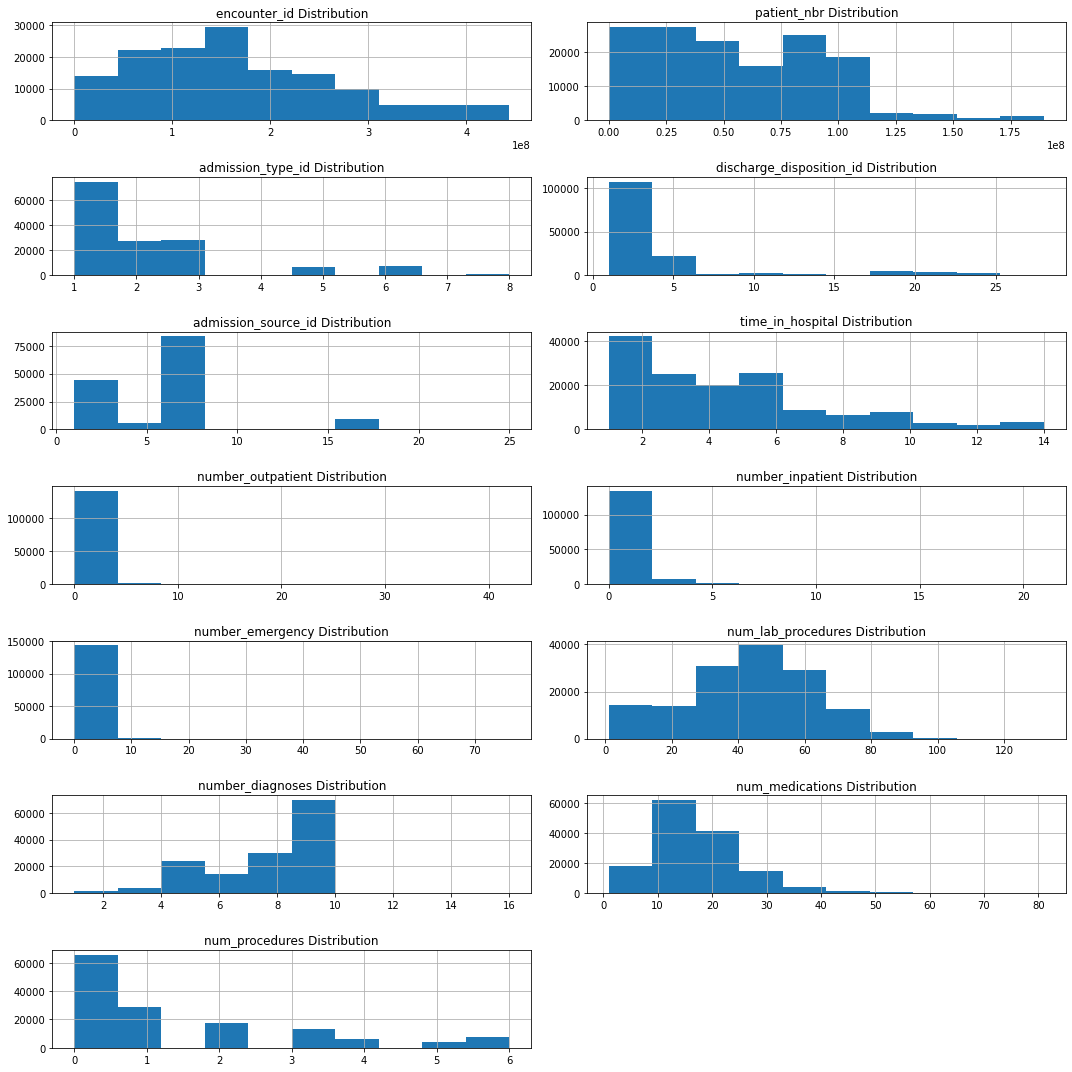

In [19]:
draw_histograms(df, num_col, 7, 2)

**b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?**

**Student Response**: 
- 'num_lab_procedures' has a normal distribution.
- 'time_in_hospital' has a right skewed normal distribution.
- 'num_medications' has a right skewed normal distribution.
- 'num_diagnoses' has a left skewed normal distribution.

In [8]:
######NOTE: The visualization will only display in Chrome browser. ########
full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
tfdv.visualize_statistics(full_data_stats)

/opt/conda/lib/python3.7/site-packages/tensorflow_data_validation/arrow/arrow_util.py:236: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  types.FeaturePath([column_name]), column.data.chunk(0), weights):


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


### Cardinality:

**c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)**


Using the tfdv output, we can refer to the unique values for each categorical variable.

The following fields have high cardinality:


- medical_specialty (73)
The above field refers to the medical speciality that the patient may be referred to. Since it's a patient dependent field and a patient could have multiple disease diagnosis, this field has high cardinality.


- primary_diagnosis_code (717)
- other_diagnosis_codes (19.4K)
- ndc_code (251)

The fields above are all medical code fields used for encoding diagnoses, medications, procedures, lab tests etc. For example ndc_code field represents drug codes maintained by the FDA. In the dataset, it represents codes for each drug prescribed to the patient and hence such high cardinality.

### Demographic Distributions:

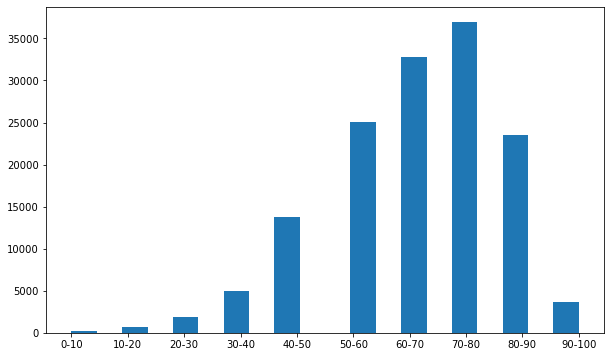

In [21]:
# histogram of patient's age
plt.figure(figsize=(10,6))
plt.hist(df['age'], bins=20,);

The dataset is biased towards age groups between 30 and 90. Hence, any predictive model based on this data will not provide good results for age groups 0 to 30 and greater than 90.

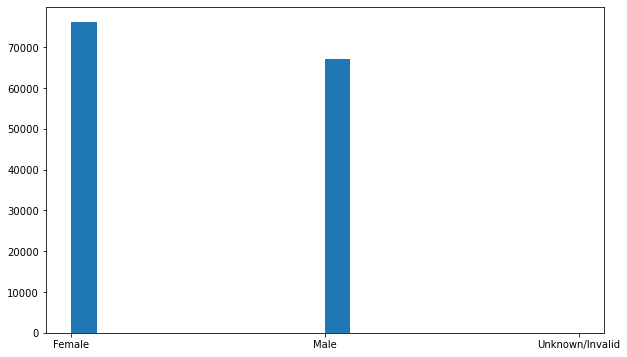

In [22]:
# histogram of patient's gender
plt.figure(figsize=(10,6))
plt.hist(df['gender'], bins=20,);

The data has more females compared with males. Although females have a slightly higher count, the male and female are well represented in the dataset and should not lead to any gender bias.


There are very few values where gender is 'Unknown/Invalid'.


Age distribution by gender:

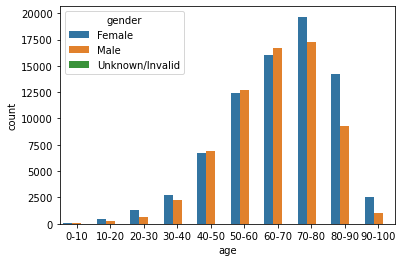

In [23]:
ax = sns.countplot(x="age", hue="gender", data=df)

**d. Please describe the demographic distributions in the dataset for the age and gender fields.**


- The dataset is biased towards age groups between 30 and 90. Hence, any predictive model based on this data will not provide good results for age groups 0 to 30 and greater than 90.
- The data has more females compared with males. Although females have a slightly higher count, the male and female are well represented in the dataset and should not lead to any gender bias. There are very few values where gender is 'Unknown/Invalid'.
- The age distribution by gender presents slightly different picture. While all of the age groups have almost equal representation between male and females, the 80-90 age group is skewed towards females. There are chances that the predictive ability of the model for males within 80-90 may not be as good as females. 
- The third gender category has a very small count and hence should be considered out-of-scope from model's prediction.

**Race:**

We can see from the below graph that 'Caucasian' is over represented in this dataset. In order for the drug to be effective across all populations, we should select a dataset which is more representative of all races to achieve demographic parity.

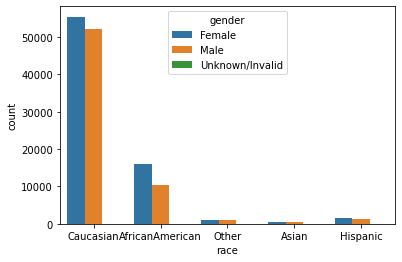

In [14]:
ax_r = sns.countplot(x="race", hue="gender", data=df)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [15]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

Clean NDC code file:

In [16]:
# lowercase column names.
ndc_code_df.columns = [x.lower() for x in ndc_code_df.columns]
ndc_code_df.columns = [x.replace(' ', '_') for x in ndc_code_df.columns]

In [17]:
# remove any duplicates
ndc_code_df.drop_duplicates(keep='first', inplace=True)
ndc_code_df.shape

(267, 7)

In [18]:
ndc_code_df.head(2)

,ndc_code,proprietary_name,non-proprietary_name,dosage_form,route_name,company_name,product_type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [19]:
# Use the non-proprietary_name field as generic drug name.
ndc_code_df['generic_drug_name'] = ndc_code_df['non-proprietary_name']

In [20]:
from student_utils import reduce_dimension_ndc

In [21]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df.shape

(143424, 26)

In [22]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [23]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [24]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [25]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [26]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Following fields are Null or NaN:

- weight 97.000502
- payer_code 37.783077
- medical_specialty 48.431922
- other_diagnosis_codes 0.237059
- ndc_code 16.358490


Following fields have zeros:

- number_outpatient 83.686831
- number_inpatient 67.421073
- number_emergency 88.858211
- num_procedures 45.869589

**Student response:**

Categorical fields:

- 'weight', 'payer_code', 'medical_speciality' should be ignored because they have high % of Null values.
- 'ndc_code' is replaced by 'generic_drug_names' to reduce cardinality, which is then converted into separate features.


Numerical fields:

- 'number_outpatient', 'number_inpatient', 'number_emergency' and 'num_procedures' should be ignored because of high % of zeros.

In [27]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ['admission_type_id', 'discharge_disposition_id','admission_source_id', 
                                'primary_diagnosis_code', 'other_diagnosis_codes',
                                'max_glu_serum', 'A1Cresult', 'change', 'readmitted'] \
                                + required_demo_col_list + ndc_col_list
student_numerical_col_list = [ 'num_lab_procedures', 'number_diagnoses', 'num_medications']
PREDICTOR_FIELD = 'time_in_hospital'

In [28]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [29]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [30]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [31]:
processed_df.tail(10)

,patient_nbr,time_in_hospital,admission_type_id,discharge_disposition_id,admission_source_id,primary_diagnosis_code,other_diagnosis_codes,max_glu_serum,A1Cresult,change,readmitted,race,gender,age,Acarbose,Glimepiride,Glipizide,Glyburide,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,num_lab_procedures,number_diagnoses,num_medications
911,80256915,11.0,1,3,7,733,599|41,None,None,Ch,NO,Caucasian,Female,80-90,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,68,9,28
912,111222522,8.0,1,1,7,410,998|414,None,>8,Ch,>30,Caucasian,Female,70-80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,87,9,46
913,44945478,5.0,1,1,7,558,555|250,None,None,No,NO,Caucasian,Male,70-80,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,45,9,17
914,94573413,3.0,1,1,7,410,486|466,None,None,No,NO,Caucasian,Male,80-90,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,82,9,19
915,90853668,3.0,3,1,1,410,250|427,None,None,Ch,NO,Caucasian,Male,90-100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,69,7,7
916,123812618,1.0,1,1,7,584,403|438,None,None,No,NO,AfricanAmerican,Male,70-80,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,69,9,20
917,52653654,7.0,1,1,7,552,250,None,None,No,NO,Caucasian,Male,60-70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,54,2,14
918,117516146,4.0,1,1,7,250.8,707|682,None,Norm,No,NO,Caucasian,Male,30-40,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,49,6,7
919,97708986,13.0,1,3,7,486,511|276,None,None,Ch,NO,Caucasian,Female,70-80,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,82,9,22
920,113392368,2.0,2,1,1,786,401|272,None,None,No,>30,AfricanAmerican,Male,60-70,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,53,9,14


## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [70]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

Total number of unique patients in train =  553
Total number of unique patients in validation =  184
Total number of unique patients in test =  184
Training partition has a shape =  (553, 29)
Validation partition has a shape =  (184, 29)
Test partition has a shape =  (184, 29)


In [71]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [72]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0      93
2.0     158
3.0     188
4.0     145
5.0      87
6.0      74
7.0      54
8.0      37
9.0      27
10.0     15
11.0     15
12.0     14
13.0     11
14.0      3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


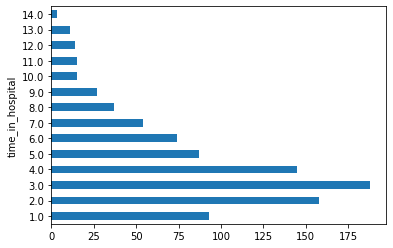

In [73]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0      63
2.0     102
3.0     114
4.0      77
5.0      53
6.0      41
7.0      32
8.0      22
9.0      17
10.0      7
11.0     11
12.0      8
13.0      4
14.0      2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


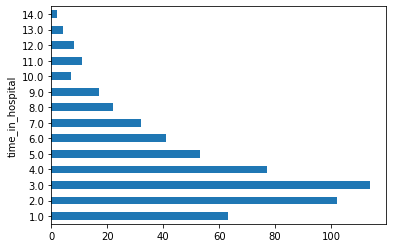

In [74]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     17
2.0     26
3.0     35
4.0     37
5.0     20
6.0     16
7.0     13
8.0      6
9.0      3
10.0     3
11.0     1
12.0     3
13.0     3
14.0     1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


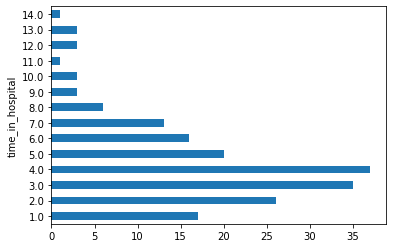

In [75]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

Yes the histograms across the partitioned datasets are similar.

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    461
Male      460
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


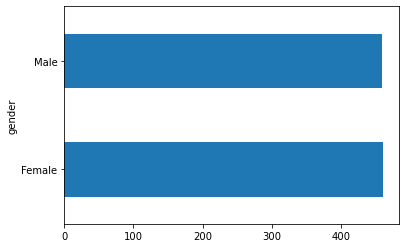

In [76]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    271
Male      282
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


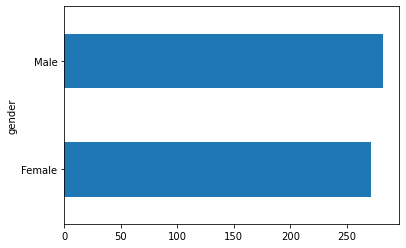

In [77]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    91
Male      93
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


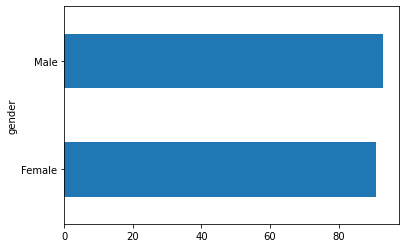

In [78]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [79]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [80]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [81]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [82]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 4 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 11 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 11 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 6 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 6 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 146 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.


INFO:tensorflow:vocabulary_size = 146 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.


INFO:tensorflow:vocabulary_size = 411 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.


INFO:tensorflow:vocabulary_size = 411 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.


INFO:tensorflow:vocabulary_size = 2 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.


INFO:tensorflow:vocabulary_size = 2 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.


INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.


INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.


INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.


INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glipizide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glipizide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyburide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyburide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Human_Insulin is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Human_Insulin_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Human_Insulin is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Human_Insulin_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Insulin_Human is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Insulin_Human_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Insulin_Human is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Insulin_Human_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Nateglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Nateglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Nateglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Nateglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Pioglitazone is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Pioglitazone is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Repaglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Repaglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Repaglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Repaglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Rosiglitazone_Maleate is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Rosiglitazone_Maleate_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Rosiglitazone_Maleate is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Rosiglitazone_Maleate_vocab.txt.


In [83]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=4, num_oov_buckets=0, dtype=tf.string, default_value=-1), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fe2f84b6790>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)
tf.Tensor(
[[ 0.01578691 -0.05293588 -0.01207654 ... -0.28761226  0.01806102
  -0.09837748]
 [-0.04548262 -0.4267331   0.10177326 ...  0.29957083  0.4106229
  -0.18665296]
 [-0.04548262 -0.4267331   0.10177326 ...  0.29957083  0.4106229
  -0.18665296]
 ...
 [ 0.01578691 -0.05293588 -0.01207654 ... -0.28761226  0.01806102
  -0.09837748]
 [-0.04548262 -0.4267331   0.10177326 ...  0.29957083  0.4106229
  -0.18665296]
 [ 0.01578691 -0.05293588 -0.01207654 ... -0.28761226  0.01806102
  -0.09837748]], shape=(128, 10), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [84]:
#import student_utils
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [85]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [86]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [87]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7fe30aee6b00>, mean=52.151898734177216, std=19.352809429158363))

tf.Tensor(
[[ 0.10526316]
 [ 0.5263158 ]
 [-0.68421054]
 [-1.0526316 ]
 [ 0.57894737]
 [ 0.94736844]
 [ 1.4210526 ]
 [-0.21052632]
 [ 1.4736842 ]
 [ 1.0526316 ]
 [-1.2631578 ]
 [ 0.8947368 ]
 [ 0.10526316]
 [-0.6315789 ]
 [-0.68421054]
 [ 0.31578946]
 [-0.10526316]
 [ 0.36842105]
 [-0.36842105]
 [-0.57894737]
 [ 1.        ]
 [-0.21052632]
 [-0.15789473]
 [ 0.42105263]
 [-1.0526316 ]
 [ 1.        ]
 [ 0.21052632]
 [ 0.15789473]
 [ 1.2631578 ]
 [ 0.31578946]
 [-1.0526316 ]
 [ 0.7894737 ]
 [-1.2631578 ]
 [ 1.8421053 ]
 [-0.42105263]
 [ 0.7368421 ]
 [ 0.10526316]
 [ 0.36842105]
 [ 0.15789473]
 [ 0.6315789 ]
 [-0.94736844]
 [-1.2631578 ]
 [ 0.6315789 ]
 [ 0.8947368 ]
 [ 0.8947368 ]
 [ 1.3684211 ]
 [-0.5263158 ]
 [-0.47368422]
 [ 0.47368

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [88]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [89]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=500)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [90]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  1000)

Train for 5 steps, validate for 2 steps
Epoch 1/1000
5/5 [==============================] - 9s 2s/step - loss: 34.6025 - mse: 37.9857 - val_loss: 54.6493 - val_mse: 66.7158
Epoch 2/1000
5/5 [==============================] - 0s 28ms/step - loss: 29.8006 - mse: 27.6905 - val_loss: 32.8375 - val_mse: 39.9688
Epoch 3/1000
5/5 [==============================] - 0s 29ms/step - loss: 24.0688 - mse: 26.0291 - val_loss: 13.6123 - val_mse: 13.8697
Epoch 4/1000
5/5 [==============================] - 0s 30ms/step - loss: 32.0995 - mse: 25.6970 - val_loss: 33.1174 - val_mse: 41.6126
Epoch 5/1000
5/5 [==============================] - 0s 30ms/step - loss: 27.6991 - mse: 29.0454 - val_loss: 17.5107 - val_mse: 19.2232
Epoch 6/1000
5/5 [==============================] - 0s 30ms/step - loss: 21.1251 - mse: 22.2905 - val_loss: 41.1662 - val_mse: 49.8169
Epoch 7/1000
5/5 [==============================] - 0s 29ms/step - loss: 30.5429 - mse: 32.7011 - val_loss: 17.4145 - val_mse: 15.5544
Epoch 8/1000
5/5 

5/5 [==============================] - 0s 29ms/step - loss: 14.6722 - mse: 14.9572 - val_loss: 16.5716 - val_mse: 17.5359
Epoch 62/1000
5/5 [==============================] - 0s 29ms/step - loss: 8.8263 - mse: 8.0321 - val_loss: 31.6384 - val_mse: 37.3887
Epoch 63/1000
5/5 [==============================] - 0s 29ms/step - loss: 16.4522 - mse: 14.5415 - val_loss: 12.5223 - val_mse: 13.3665
Epoch 64/1000
5/5 [==============================] - 0s 29ms/step - loss: 11.8491 - mse: 11.6085 - val_loss: 10.2847 - val_mse: 8.6960
Epoch 65/1000
5/5 [==============================] - 0s 30ms/step - loss: 30.3943 - mse: 29.3329 - val_loss: 28.4294 - val_mse: 35.8447
Epoch 66/1000
5/5 [==============================] - 0s 30ms/step - loss: 20.6151 - mse: 21.7879 - val_loss: 17.5489 - val_mse: 14.2296
Epoch 67/1000
5/5 [==============================] - 0s 29ms/step - loss: 21.1811 - mse: 21.2254 - val_loss: 20.8611 - val_mse: 15.7575
Epoch 68/1000
5/5 [==============================] - 0s 30ms/step

5/5 [==============================] - 0s 30ms/step - loss: 12.7627 - mse: 12.9840 - val_loss: 10.7832 - val_mse: 9.4730
Epoch 122/1000
5/5 [==============================] - 0s 30ms/step - loss: 16.5006 - mse: 18.3434 - val_loss: 14.2488 - val_mse: 15.2094
Epoch 123/1000
5/5 [==============================] - 0s 29ms/step - loss: 13.8174 - mse: 14.6201 - val_loss: 10.1028 - val_mse: 8.1623
Epoch 124/1000
5/5 [==============================] - 0s 31ms/step - loss: 8.6256 - mse: 7.1156 - val_loss: 8.5247 - val_mse: 7.3616
Epoch 125/1000
5/5 [==============================] - 0s 30ms/step - loss: 10.0784 - mse: 8.7824 - val_loss: 20.4344 - val_mse: 25.1642
Epoch 126/1000
5/5 [==============================] - 0s 31ms/step - loss: 20.5386 - mse: 22.9594 - val_loss: 26.8292 - val_mse: 23.1682
Epoch 127/1000
5/5 [==============================] - 0s 30ms/step - loss: 14.8636 - mse: 15.4167 - val_loss: 34.6576 - val_mse: 45.3879
Epoch 128/1000
5/5 [==============================] - 0s 29ms/s

5/5 [==============================] - 0s 30ms/step - loss: 10.6859 - mse: 10.1738 - val_loss: 9.9700 - val_mse: 8.8650
Epoch 182/1000
5/5 [==============================] - 0s 30ms/step - loss: 7.1487 - mse: 6.2727 - val_loss: 8.6601 - val_mse: 6.9182
Epoch 183/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.5900 - mse: 2.6503 - val_loss: 8.0972 - val_mse: 6.2038
Epoch 184/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.7998 - mse: 6.8339 - val_loss: 9.7119 - val_mse: 8.9885
Epoch 185/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.5975 - mse: 5.7708 - val_loss: 13.2868 - val_mse: 14.8656
Epoch 186/1000
5/5 [==============================] - 0s 30ms/step - loss: 22.5393 - mse: 25.7780 - val_loss: 11.6354 - val_mse: 11.3077
Epoch 187/1000
5/5 [==============================] - 0s 31ms/step - loss: 8.8266 - mse: 8.0155 - val_loss: 10.6275 - val_mse: 7.8351
Epoch 188/1000
5/5 [==============================] - 0s 31ms/step - loss: 

5/5 [==============================] - 0s 30ms/step - loss: 12.3959 - mse: 11.1867 - val_loss: 12.7702 - val_mse: 12.4335
Epoch 243/1000
5/5 [==============================] - 0s 31ms/step - loss: 8.0836 - mse: 8.4141 - val_loss: 8.6512 - val_mse: 7.6385
Epoch 244/1000
5/5 [==============================] - 0s 32ms/step - loss: 5.2141 - mse: 3.3058 - val_loss: 17.0480 - val_mse: 17.6146
Epoch 245/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.1311 - mse: 4.3056 - val_loss: 19.4007 - val_mse: 20.2531
Epoch 246/1000
5/5 [==============================] - 0s 35ms/step - loss: 11.0814 - mse: 8.8965 - val_loss: 9.3801 - val_mse: 7.0034
Epoch 247/1000
5/5 [==============================] - 0s 30ms/step - loss: 9.2449 - mse: 8.5541 - val_loss: 8.8524 - val_mse: 7.4263
Epoch 248/1000
5/5 [==============================] - 0s 30ms/step - loss: 11.2029 - mse: 8.3922 - val_loss: 8.9117 - val_mse: 9.6721
Epoch 249/1000
5/5 [==============================] - 0s 31ms/step - loss:

5/5 [==============================] - 0s 28ms/step - loss: 8.0902 - mse: 7.5562 - val_loss: 9.8635 - val_mse: 7.7704
Epoch 304/1000
5/5 [==============================] - 0s 29ms/step - loss: 4.7686 - mse: 3.6612 - val_loss: 13.0553 - val_mse: 11.6476
Epoch 305/1000
5/5 [==============================] - 0s 29ms/step - loss: 4.6908 - mse: 4.2687 - val_loss: 10.0435 - val_mse: 8.8041
Epoch 306/1000
5/5 [==============================] - 0s 29ms/step - loss: 6.6487 - mse: 6.4679 - val_loss: 12.5662 - val_mse: 10.1415
Epoch 307/1000
5/5 [==============================] - 0s 30ms/step - loss: 5.3988 - mse: 4.7542 - val_loss: 9.0964 - val_mse: 7.0663
Epoch 308/1000
5/5 [==============================] - 0s 31ms/step - loss: 9.6560 - mse: 8.6664 - val_loss: 9.4039 - val_mse: 7.1791
Epoch 309/1000
5/5 [==============================] - 0s 30ms/step - loss: 9.7448 - mse: 10.9325 - val_loss: 8.1420 - val_mse: 8.6349
Epoch 310/1000
5/5 [==============================] - 0s 28ms/step - loss: 15.

5/5 [==============================] - 0s 31ms/step - loss: 5.3896 - mse: 4.8922 - val_loss: 11.3482 - val_mse: 8.8345
Epoch 365/1000
5/5 [==============================] - 0s 29ms/step - loss: 8.1640 - mse: 5.8870 - val_loss: 11.9917 - val_mse: 8.7259
Epoch 366/1000
5/5 [==============================] - 0s 30ms/step - loss: 5.0128 - mse: 4.1484 - val_loss: 10.4545 - val_mse: 10.4172
Epoch 367/1000
5/5 [==============================] - 0s 29ms/step - loss: 4.4748 - mse: 2.7949 - val_loss: 19.5533 - val_mse: 16.7658
Epoch 368/1000
5/5 [==============================] - 0s 29ms/step - loss: 2.6221 - mse: 1.1433 - val_loss: 13.5605 - val_mse: 10.6272
Epoch 369/1000
5/5 [==============================] - 0s 29ms/step - loss: 9.4248 - mse: 10.2916 - val_loss: 18.1656 - val_mse: 16.6910
Epoch 370/1000
5/5 [==============================] - 0s 29ms/step - loss: 3.8136 - mse: 3.6362 - val_loss: 9.5861 - val_mse: 7.6441
Epoch 371/1000
5/5 [==============================] - 0s 29ms/step - loss

5/5 [==============================] - 0s 31ms/step - loss: 7.2962 - mse: 6.4360 - val_loss: 11.7568 - val_mse: 9.9291
Epoch 426/1000
5/5 [==============================] - 0s 31ms/step - loss: 1.6311 - mse: 1.3846 - val_loss: 14.6517 - val_mse: 12.2617
Epoch 427/1000
5/5 [==============================] - 0s 31ms/step - loss: 2.5840 - mse: 2.0152 - val_loss: 11.7226 - val_mse: 13.4873
Epoch 428/1000
5/5 [==============================] - 0s 31ms/step - loss: 2.9864 - mse: 2.8997 - val_loss: 10.9149 - val_mse: 11.1633
Epoch 429/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.2832 - mse: 2.4387 - val_loss: 12.4517 - val_mse: 11.4640
Epoch 430/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.3760 - mse: 2.7081 - val_loss: 10.8455 - val_mse: 9.0414
Epoch 431/1000
5/5 [==============================] - 0s 31ms/step - loss: 7.0927 - mse: 4.0702 - val_loss: 10.9708 - val_mse: 8.9575
Epoch 432/1000
5/5 [==============================] - 0s 30ms/step - loss

5/5 [==============================] - 0s 31ms/step - loss: 2.6466 - mse: 2.4643 - val_loss: 13.1241 - val_mse: 10.1820
Epoch 487/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.1078 - mse: 2.3375 - val_loss: 10.1537 - val_mse: 8.7373
Epoch 488/1000
5/5 [==============================] - 0s 31ms/step - loss: 5.8975 - mse: 4.9080 - val_loss: 9.8770 - val_mse: 9.3789
Epoch 489/1000
5/5 [==============================] - 0s 29ms/step - loss: 7.7862 - mse: 8.0030 - val_loss: 9.1947 - val_mse: 8.0858
Epoch 490/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.4792 - mse: 3.3064 - val_loss: 7.7687 - val_mse: 7.6557
Epoch 491/1000
5/5 [==============================] - 0s 29ms/step - loss: 4.8848 - mse: 3.0934 - val_loss: 19.2333 - val_mse: 13.1246
Epoch 492/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.3333 - mse: 3.6432 - val_loss: 10.9501 - val_mse: 8.7211
Epoch 493/1000
5/5 [==============================] - 0s 30ms/step - loss: 5.3

5/5 [==============================] - 0s 30ms/step - loss: 4.4112 - mse: 2.8583 - val_loss: 12.3785 - val_mse: 10.7446
Epoch 548/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.9909 - mse: 1.7034 - val_loss: 11.4511 - val_mse: 11.5755
Epoch 549/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.1538 - mse: 3.5296 - val_loss: 8.7149 - val_mse: 9.5211
Epoch 550/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.7445 - mse: 4.5034 - val_loss: 14.1747 - val_mse: 11.2247
Epoch 551/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.9371 - mse: 4.5506 - val_loss: 11.7481 - val_mse: 11.1251
Epoch 552/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.3123 - mse: 1.0950 - val_loss: 7.8672 - val_mse: 7.3153
Epoch 553/1000
5/5 [==============================] - 0s 31ms/step - loss: 2.6752 - mse: 1.4609 - val_loss: 10.4353 - val_mse: 11.1718
Epoch 554/1000
5/5 [==============================] - 0s 31ms/step - loss:

5/5 [==============================] - 0s 29ms/step - loss: 3.2969 - mse: 2.3649 - val_loss: 8.2875 - val_mse: 8.3226
Epoch 609/1000
5/5 [==============================] - 0s 29ms/step - loss: 6.8950 - mse: 4.8397 - val_loss: 13.5497 - val_mse: 14.3978
Epoch 610/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.6766 - mse: 2.9611 - val_loss: 7.6905 - val_mse: 7.7229
Epoch 611/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.5768 - mse: 3.5391 - val_loss: 10.7088 - val_mse: 8.0544
Epoch 612/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.7656 - mse: 2.3882 - val_loss: 10.0084 - val_mse: 9.9015
Epoch 613/1000
5/5 [==============================] - 0s 29ms/step - loss: 3.2415 - mse: 2.1134 - val_loss: 10.1688 - val_mse: 8.6626
Epoch 614/1000
5/5 [==============================] - 0s 28ms/step - loss: 8.8483 - mse: 7.1028 - val_loss: 12.4733 - val_mse: 11.5689
Epoch 615/1000
5/5 [==============================] - 0s 28ms/step - loss: 6.

5/5 [==============================] - 0s 32ms/step - loss: 6.8362 - mse: 5.8210 - val_loss: 13.6459 - val_mse: 10.5542
Epoch 670/1000
5/5 [==============================] - 0s 31ms/step - loss: 2.0879 - mse: 1.3882 - val_loss: 13.3652 - val_mse: 15.1386
Epoch 671/1000
5/5 [==============================] - 0s 30ms/step - loss: 5.6577 - mse: 4.7176 - val_loss: 9.9752 - val_mse: 8.3899
Epoch 672/1000
5/5 [==============================] - 0s 31ms/step - loss: 4.9694 - mse: 4.0033 - val_loss: 9.9109 - val_mse: 9.2114
Epoch 673/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.5621 - mse: 3.9899 - val_loss: 14.9724 - val_mse: 18.4610
Epoch 674/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.2693 - mse: 1.9901 - val_loss: 12.9695 - val_mse: 10.8725
Epoch 675/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.3996 - mse: 3.0421 - val_loss: 9.1166 - val_mse: 8.3925
Epoch 676/1000
5/5 [==============================] - 0s 31ms/step - loss: 4

5/5 [==============================] - 0s 32ms/step - loss: 4.1113 - mse: 4.7772 - val_loss: 12.2375 - val_mse: 11.8187
Epoch 731/1000
5/5 [==============================] - 0s 32ms/step - loss: 4.4245 - mse: 3.1454 - val_loss: 8.4593 - val_mse: 8.3056
Epoch 732/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.7909 - mse: 2.4411 - val_loss: 9.9696 - val_mse: 9.5746
Epoch 733/1000
5/5 [==============================] - 0s 31ms/step - loss: 4.3489 - mse: 4.9783 - val_loss: 8.6567 - val_mse: 8.1082
Epoch 734/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.2791 - mse: 1.7628 - val_loss: 14.9878 - val_mse: 13.3734
Epoch 735/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.3467 - mse: 1.5418 - val_loss: 12.7409 - val_mse: 13.6139
Epoch 736/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.5352 - mse: 3.0980 - val_loss: 8.5733 - val_mse: 8.3008
Epoch 737/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.9

5/5 [==============================] - 0s 31ms/step - loss: 4.2655 - mse: 2.0028 - val_loss: 9.1809 - val_mse: 9.0807
Epoch 792/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.2596 - mse: 2.0563 - val_loss: 11.5215 - val_mse: 8.3622
Epoch 793/1000
5/5 [==============================] - 0s 34ms/step - loss: 3.3336 - mse: 1.1770 - val_loss: 9.7477 - val_mse: 8.4450
Epoch 794/1000
5/5 [==============================] - 0s 31ms/step - loss: 4.4757 - mse: 1.8457 - val_loss: 11.2943 - val_mse: 9.9767
Epoch 795/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.3620 - mse: 2.7985 - val_loss: 10.9264 - val_mse: 10.7929
Epoch 796/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.4269 - mse: 3.2718 - val_loss: 12.5285 - val_mse: 9.4351
Epoch 797/1000
5/5 [==============================] - 0s 29ms/step - loss: 2.5503 - mse: 2.5250 - val_loss: 12.5831 - val_mse: 14.1837
Epoch 798/1000
5/5 [==============================] - 0s 29ms/step - loss: 2.

5/5 [==============================] - 0s 29ms/step - loss: 2.5248 - mse: 2.0182 - val_loss: 17.4185 - val_mse: 13.3488
Epoch 853/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.2952 - mse: 1.6811 - val_loss: 9.0212 - val_mse: 8.6575
Epoch 854/1000
5/5 [==============================] - 0s 29ms/step - loss: 5.1739 - mse: 4.6136 - val_loss: 12.8952 - val_mse: 13.5323
Epoch 855/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.1272 - mse: 1.5044 - val_loss: 12.0853 - val_mse: 10.4081
Epoch 856/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.8558 - mse: 2.0481 - val_loss: 7.6430 - val_mse: 8.9874
Epoch 857/1000
5/5 [==============================] - 0s 31ms/step - loss: 6.0232 - mse: 4.9287 - val_loss: 11.7607 - val_mse: 9.3229
Epoch 858/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.4806 - mse: 1.4256 - val_loss: 9.4241 - val_mse: 8.9386
Epoch 859/1000
5/5 [==============================] - 0s 29ms/step - loss: 5.

5/5 [==============================] - 0s 35ms/step - loss: 4.9049 - mse: 3.5354 - val_loss: 16.3288 - val_mse: 14.1414
Epoch 914/1000
5/5 [==============================] - 0s 33ms/step - loss: 4.9170 - mse: 3.6293 - val_loss: 9.8970 - val_mse: 8.9424
Epoch 915/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.1585 - mse: 1.9581 - val_loss: 10.3198 - val_mse: 9.4670
Epoch 916/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.7552 - mse: 3.6978 - val_loss: 9.1204 - val_mse: 8.3369
Epoch 917/1000
5/5 [==============================] - 0s 31ms/step - loss: 2.1887 - mse: 1.9438 - val_loss: 10.0610 - val_mse: 9.4756
Epoch 918/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.5701 - mse: 1.6779 - val_loss: 9.9727 - val_mse: 9.1853
Epoch 919/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.9914 - mse: 2.6850 - val_loss: 10.2030 - val_mse: 8.7784
Epoch 920/1000
5/5 [==============================] - 0s 35ms/step - loss: 3.36

5/5 [==============================] - 0s 31ms/step - loss: 2.2553 - mse: 1.8822 - val_loss: 15.4501 - val_mse: 14.2917
Epoch 975/1000
5/5 [==============================] - 0s 31ms/step - loss: 4.7231 - mse: 5.1192 - val_loss: 11.2821 - val_mse: 9.6674
Epoch 976/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.3093 - mse: 6.0082 - val_loss: 10.4227 - val_mse: 8.2383
Epoch 977/1000
5/5 [==============================] - 0s 31ms/step - loss: 4.0886 - mse: 2.4693 - val_loss: 12.0060 - val_mse: 9.3239
Epoch 978/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.0168 - mse: 1.8993 - val_loss: 11.9789 - val_mse: 11.6885
Epoch 979/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.6136 - mse: 3.3687 - val_loss: 12.2711 - val_mse: 10.5892
Epoch 980/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.7119 - mse: 3.8605 - val_loss: 7.6788 - val_mse: 8.4523
Epoch 981/1000
5/5 [==============================] - 0s 29ms/step - loss: 

In [91]:
diabetes_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_5 (DenseFeatu multiple                  6570      
_________________________________________________________________
dense_2 (Dense)              multiple                  36600     
_________________________________________________________________
dense_3 (Dense)              multiple                  11325     
_________________________________________________________________
dense_variational_1 (DenseVa multiple                  456       
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 54,951
Trainable params: 54,951
Non-trainable params: 0
_________________________________________________________________


## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [92]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [93]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [94]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [95]:
prob_output_df.head(20)

,pred,actual_value,pred_mean,pred_std
0,2.285726,9.0,3.006067,0.689004
1,0.958798,3.0,1.392050,0.689482
2,-0.083171,4.0,3.389459,0.689060
3,0.947840,4.0,4.607674,0.687843
4,1.030754,4.0,4.641978,0.688946
5,0.119610,5.0,1.316329,0.689936
6,0.023077,4.0,4.489628,0.687605
7,1.645539,7.0,9.769547,0.682258
8,2.647990,1.0,1.382965,0.690311
9,1.711818,4.0,5.243450,0.688802


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [134]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [135]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [136]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head(20)

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,34511220,Female,Caucasian,9.0,0,1
1,39852603,Female,Caucasian,3.0,0,0
2,81362061,Female,Caucasian,4.0,0,0
3,64593639,Female,Caucasian,4.0,0,0
4,64296630,Female,Caucasian,4.0,0,0
5,47343420,Male,Caucasian,5.0,0,1
6,112874778,Female,Caucasian,4.0,0,0
7,77730093,Female,Caucasian,7.0,1,1
8,104704110,Female,Caucasian,1.0,0,0
9,69823296,Male,Caucasian,4.0,1,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [137]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, roc_curve

In [138]:
y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values

In [139]:
# functions to plot AUC and Confusion matrix.
def plot_auc(t_y, p_y):
    '''
    Function to plot Roc curve.
    
    Input:
    t_y - true label
    p_y - predicted label
    
    '''
   
    print("ROC AUC Score: {}".format(roc_auc_score(t_y, p_y)))
    
    # plot roc curve
    fpr, tpr, _ = roc_curve(t_y, p_y)
    fig, ax = plt.subplots(1,1, figsize = (5, 5))
    ax.plot(fpr, tpr, 'b.-', label = 'VGG-Model')
    ax.plot(fpr, fpr, 'k-', label = 'Random Guessing')
    #ax.legend(loc = 4)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate');
    
    return


def plot_confusion_mat(t_y, p_y):
    '''
    Function to plot confusion matrix.
    Input:
    t_y - true label
    p_y - predicted label
    thresh - threshold for precicted label    
    '''
    
    # confusion matrix
    conf_mat = confusion_matrix(y_true=t_y, y_pred=p_y)
    print('Confusion matrix:\n', conf_mat)
    
    # plot matrix
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

1. Roc curve Sensitivity Vs Specificity

 - Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
 - Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

ROC AUC Score: 0.6927536231884059


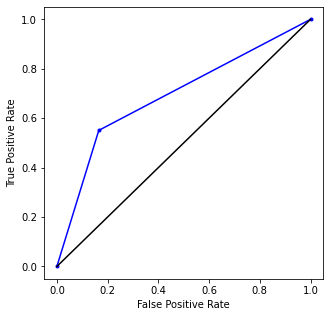

In [140]:
plot_auc(y_true, y_pred)

Since AOC > 0.5, we know our model is performing better than random classifier.

2. Precision-Recall Curve

In [141]:
# plot Precision Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

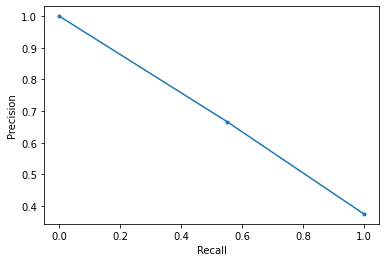

In [142]:
plt.plot(recall, precision, marker='.')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision');

3. Confusion Matrix

Confusion matrix:
 [[96 19]
 [31 38]]


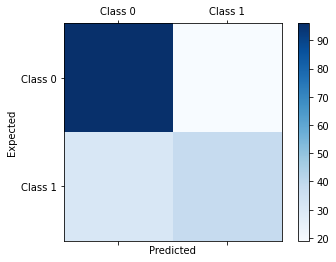

In [143]:
plot_confusion_mat(y_true, y_pred)

Student Threshold: 4
- TP: 68
- FP: 47
- FN: 14
- TN: 55

Student Threshold: 5
- TP: 96
- FP: 19
- FN: 31
- TN: 38

Student Threshold: 6
- TP: 107
- FP: 8
- FN: 42
- TN: 27

4. Classification Report

In [144]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       115
           1       0.67      0.55      0.60        69

    accuracy                           0.73       184
   macro avg       0.71      0.69      0.70       184
weighted avg       0.72      0.73      0.72       184



**Threshold 4:**

              precision    recall  f1-score   support

           0       0.83      0.59      0.69       115
           1       0.54      0.80      0.64        69

    accuracy                           0.67       184







**Threshold 5:**

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       115
           1       0.67      0.55      0.60        69

    accuracy                           0.73       184



**Threshold 6:**
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       115
           1       0.77      0.39      0.52        69

    accuracy                           0.73       184





**Precision-recall tradeoff**

- Precision is the proportion of positive identifications that are actually correct. Precision provides more confidence in a positive result. Hence, a higher precision will indicate that the patients selected by the model have been correctly identified.
- Precision ignores False Negatives. Hence, a higher precision doesn't gaurantee that the patients that were not selected for diabetes testing were actually True Negatives.

- Recall is proportion of actual positives that were identified correctly. A higher Recall provides more confidence that the test is negative. It however, ignores False Positives. 


- In the student binary score, an average time of 5 was used as the threshold. If the threshold is reduced the Recall will increase but that does not serve our purpose. In the current business context, it's better to identify patients for drug testing correctly rather than incorrectly missing them. If we increase the threshold to 6, the recall reduces. This may not be favourable as well since we will miss out on patients that can be used for drug testing. The best approach is to strike a balance between precision and recall and find the threshold that optimizes both the metrics. In the current model, using 5 as average time in hospital as threshold provides the best result.




**What are some areas of improvement for future iterations?**

- The main area of improvement is to improve the architecture of the deep learning model and perform hyper parameter tuning to get the best results.
- Another area of improvement is the imputation of missing values. Right now we used a generalized approach but in future iterations we can use more advance methods.
- It would be great to get more represntative data. As we will see in the bias analysis below, the data does not equally represent all the races.


# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [145]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)
/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


model_id, score_thresholds 1 {'rank_abs': [57]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [146]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

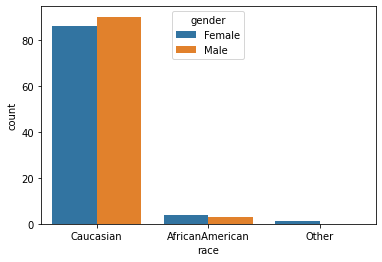

In [151]:
ax_pred_r = sns.countplot(x="race", hue="gender", data=ae_subset_df)

In [147]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,57,race,AfricanAmerican,1,6,0,1,5,1,2,5,7,184
1,1,binary 0/1,57,race,Caucasian,56,120,19,30,90,37,67,109,176,184
2,1,binary 0/1,57,race,Other,0,1,0,0,1,0,0,1,1,184
3,1,binary 0/1,57,gender,Female,24,67,8,19,48,16,35,56,91,184
4,1,binary 0/1,57,gender,Male,33,60,11,12,48,22,34,59,93,184


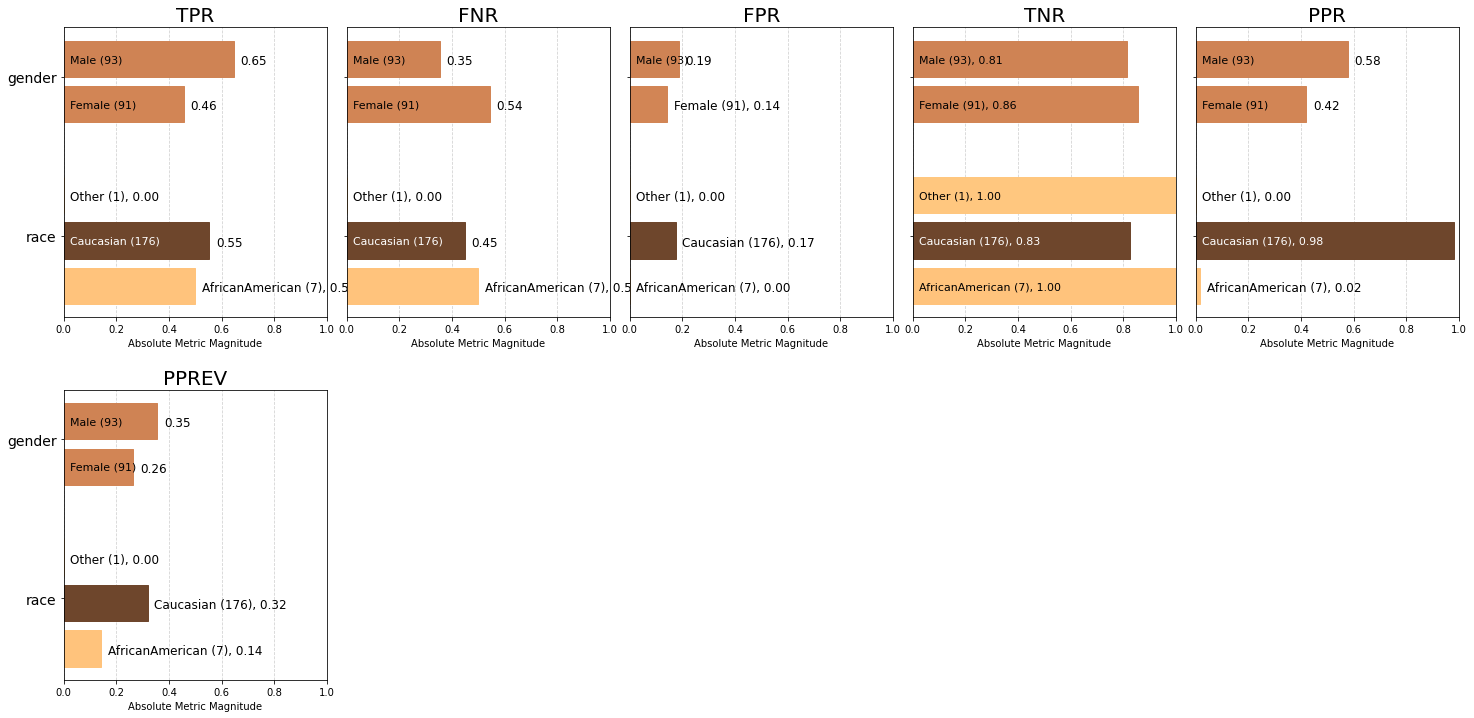

In [150]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fnr', 'fpr', 'tnr', 'ppr', 'pprev'], ncols=5)

**Is there significant bias in your model for either race or gender?**

Considering following metrics, we can see bias in both race and gender:

PPR: Predicted Positive Rate (Fraction of all positive predictions across groups that come from specific groups.)
If we consider race, can clearly see a bias here since 'Caucasian' has the highest PPR compared to other races by quite a margin.


TPR: True Positive Rate
If we consider gender, the 'Male' is likely to have higher selection relative to 'Female' since TPR is higher for Males. This implies that the model is likely to predict more Male patients for testing than females.




## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

Reference group used in fairness plot:

'race':'Caucasian', 'gender':'Male'

FPR Analysis:

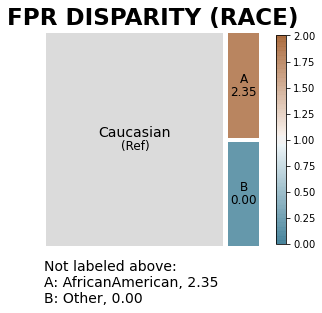

In [238]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

- The above analysis is suggesting that 'African American' 2.35 times likely to be falsely identified as a patient for drug testing versus the reference group (Male, Causasian).

- Overall, the data for 'Other' and 'African American' is so under-represented in the dataset that it should be ignored from any prediction by the model.

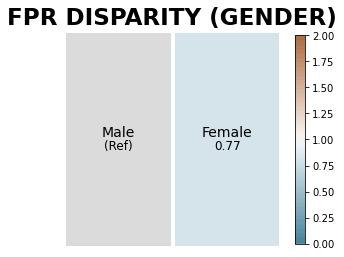

In [152]:
fpr_disparity_g = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

- The above analysis is suggesting that 'Female' is .77 times likely to be falsely identified as a patient for drug testing versus the reference group (Male). This suggests that there is less disparity at a gender level.

Absolute Value Fairness:

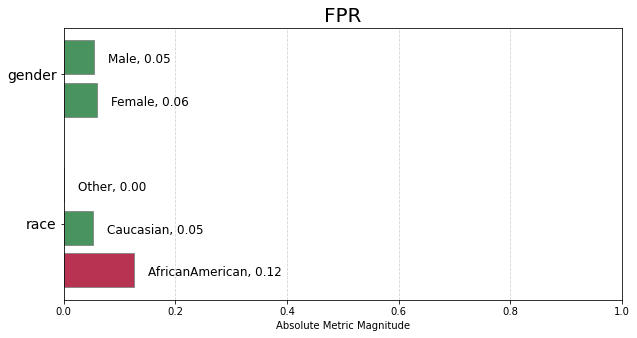

In [239]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

Absolute Value Fairness Determination

- Red = False/Not Fair
- Green = True/Fair

The above plot also identifies the bias in race where 'African American' will be falsely identified by the model.

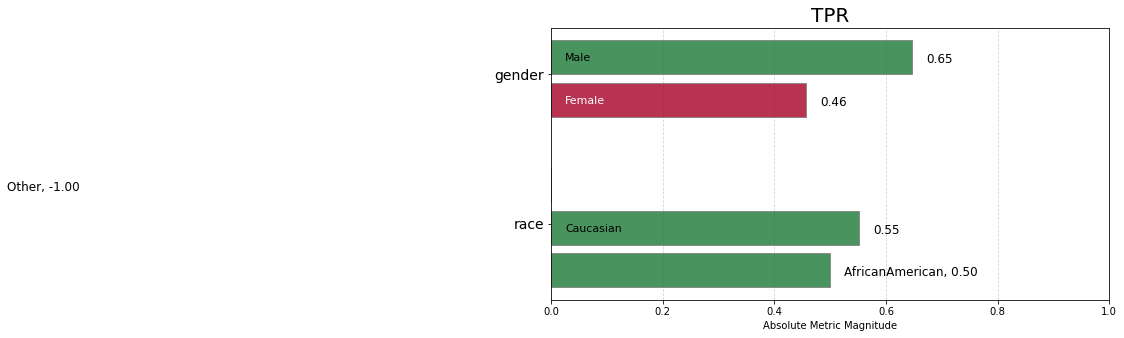

In [153]:
tpr_fairness = aqp.plot_fairness_group(fdf, group_metric='tpr', title=True)

Like we saw in the metric analysis above, there is bias towards Male patients when it comes to selecting patients for drug testing.